In [1]:
import numpy as np
import pandas as pd
import datetime
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("../../data/cooked_data/cooked_complete_dataset.csv")

df["date"] = df["date"].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%y"))

train = df[df["date"] <= "2021/03/10"]
test = df[(df["date"] > "2021/03/10") & (df["date"] <= "2021/04/05")]

train.set_index('date', inplace = True)
test.set_index('date', inplace = True)

In [3]:
def tsplot(y, lags=20, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

In [4]:
for col in train.columns:
    print(col, sm.adfuller(train[col])[1])

Adj_Close_BTC-USD 0.7581894781521595
Open_BTC-USD 0.7392578653423267
High_BTC-USD 0.7332979560606094
Low_BTC-USD 0.7587441314412278
Volume_BTC-USD 8.354566487921838e-14
Adj_Close_SPY 0.20931290475193998
Adj_Close_GLD 0.8662139786887266
Adj_Close_CHFUSD=X 0.9357803961869772
Adj_Close_CNYUSD=X 0.12715256385375806
Adj_Close_EURUSD=X 0.7249175492771132
Adj_Close_GBPUSD=X 0.23528956964917558
Adj_Close_JPYUSD=X 0.9986316951534083
coindesk_sentiment 3.9092813001944024e-14
num_of_coindesk_posts 0.24589391456368126
reddit_comments_sentiments 1.0670139126213399e-15
top_50_reddit_posts_sentiments 1.2783915677512097e-14
blockchain_transactions_per_block 0.028022551758901604
blockchain_hash_rates 0.2864238709098488


In [5]:
# differencing - first order sufficient
for col in train.columns:
    print(col, sm.adfuller(train.diff().dropna()[col])[1])

Adj_Close_BTC-USD 2.7762966372602127e-15
Open_BTC-USD 7.944892406001317e-16
High_BTC-USD 5.864740562988383e-14
Low_BTC-USD 1.446618544743508e-14
Volume_BTC-USD 1.5880326118759201e-15
Adj_Close_SPY 6.456604501396016e-16
Adj_Close_GLD 1.6456587085016845e-07
Adj_Close_CHFUSD=X 3.9612864674187265e-14
Adj_Close_CNYUSD=X 2.0948310404472046e-08
Adj_Close_EURUSD=X 2.009495412379472e-15
Adj_Close_GBPUSD=X 4.905672377100226e-09
Adj_Close_JPYUSD=X 0.00015909565963471116
coindesk_sentiment 4.113188966921004e-09
num_of_coindesk_posts 0.00023694609709517262
reddit_comments_sentiments 1.1799017170104487e-06
top_50_reddit_posts_sentiments 3.581062199782086e-13
blockchain_transactions_per_block 1.938447191590923e-14
blockchain_hash_rates 7.551395165064188e-10


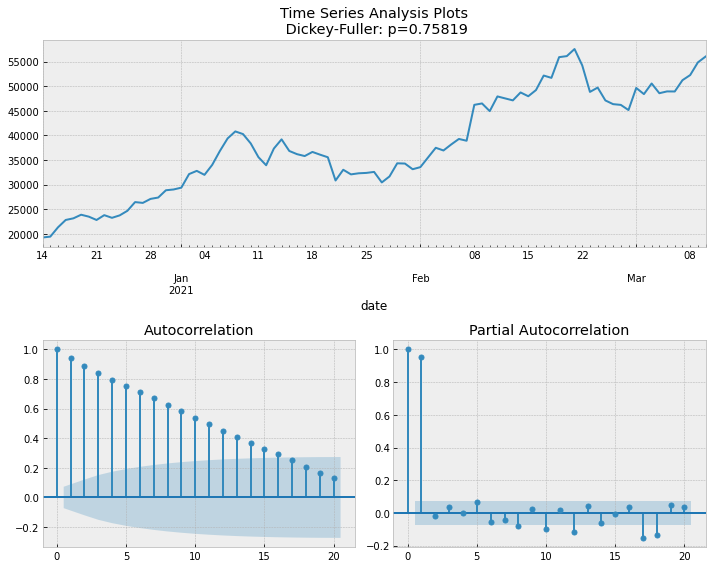

In [6]:
tsplot(train["Adj_Close_BTC-USD"])

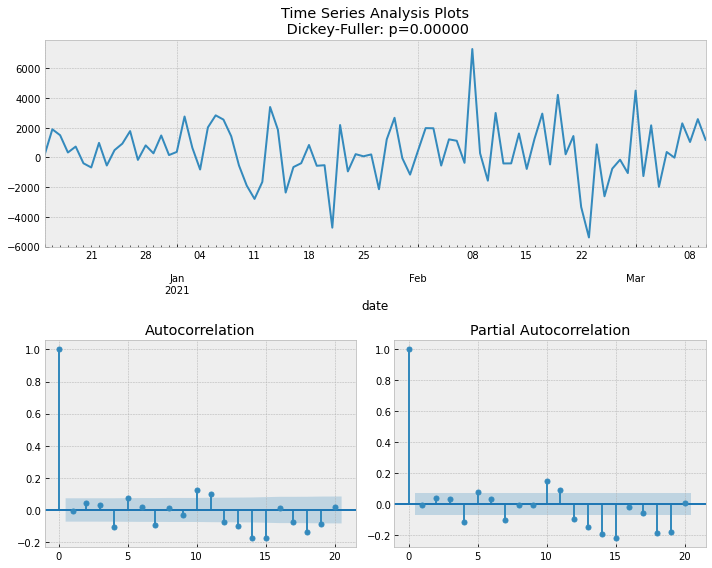

In [7]:
tsplot(train["Adj_Close_BTC-USD"].diff().dropna()) # white noise after differencing

In [8]:
df_differenced = train.diff().dropna()

In [9]:
def write_results(results, columns):
    print(results.summary())
    print("================test_whiteness================\n")
    print(results.test_whiteness(nlags=10))
    print("================results.roots()================\n")
    for root in results.roots:
        print(str(root)+",")
    print("\n================is_stable================\n")
    print(str(results.is_stable()))
    print("\n================granger causality================\n")
    for V1 in ["Adj_Close_BTC-USD"]:
        for V2 in columns:
            print("Granger test: "+V2+"-->"+V1+"\n")
            print(results.test_causality(V1, [V2],kind='f').summary())
            print("\n")

## With Sentiment

In [10]:
model = VAR(df_differenced)
print(model.select_order(3).summary()) 

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       67.50      68.02*   2.064e+29      67.71*
1       64.45       74.42  1.133e+28*       68.45
2       64.72       84.13   4.297e+28       72.52
3      60.21*       89.06   1.803e+28       71.80
-------------------------------------------------


In [11]:
lag_order = 3
results = model.fit(lag_order,trend="c")
write_results(results, train.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Apr, 2021
Time:                     00:09:17
--------------------------------------------------------------------
No. of Equations:         18.0000    BIC:                    89.0575
Nobs:                     83.0000    HQIC:                   71.7971
Log likelihood:          -3628.45    FPE:                1.80284e+28
AIC:                      60.2063    Det(Omega_mle):     1.91223e+24
--------------------------------------------------------------------
Results for equation Adj_Close_BTC-USD
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                      181.699469       320.500339            0.567           0.571
L1.Adj_Close_BTC-USD                         0.425436       

Granger causality F-test. H_0: Adj_Close_GBPUSD=X does not Granger-cause Adj_Close_BTC-USD. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.1984          2.623   0.897 (3, 504)
----------------------------------------------


Granger test: Adj_Close_JPYUSD=X-->Adj_Close_BTC-USD

Granger causality F-test. H_0: Adj_Close_JPYUSD=X does not Granger-cause Adj_Close_BTC-USD. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
     3.866e-07          2.623   1.000 (3, 504)
----------------------------------------------


Granger test: coindesk_sentiment-->Adj_Close_BTC-USD

Granger causality F-test. H_0: coindesk_sentiment does not Granger-cause Adj_Close_BTC-USD. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
--------------------------

In [12]:
# training set forecast
pred_train = []
for timestep in range(df_differenced.shape[0] - lag_order + 1):
    pred_train.append(results.forecast(y=df_differenced.values[0:timestep+lag_order], steps=1)[0][0])

predictions_train = [None, None, df.loc[lag_order-1,'Adj_Close_BTC-USD']]
for diff in pred_train:
    predictions_train.append(predictions_train[-1] + diff)

In [14]:
# test set forecast
pred_test = results.forecast(results.y, steps=len(test))[:,0]

predictions_test = [train.loc["2021-03-10",'Adj_Close_BTC-USD']]
for diff in pred_test:
    predictions_test.append(predictions_test[-1] + diff)

In [15]:
predictions = np.concatenate([predictions_train[3:], predictions_test[1:]])

In [16]:
prediction_all = pd.DataFrame(predictions, index = df.date[3:-1], columns = ['predicted'])
prediction_all['actual'] = df["Adj_Close_BTC-USD"].values[3:-1]

In [17]:
prediction_all.to_csv('with_sentiments.csv')

In [18]:
# test rmse
rmse_test = prediction_all.loc["2021/03/11":"2021/04/05"]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  3245.942486


## Without Sentiment

In [19]:
df_differenced_no_sentiment = df_differenced.drop(['coindesk_sentiment', 'num_of_coindesk_posts', 'reddit_comments_sentiments', 'top_50_reddit_posts_sentiments'], axis = 1)
model = VAR(df_differenced_no_sentiment)
print(model.select_order(3).summary()) 

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       77.97      78.38*   7.280e+33       78.13
1      75.04*       81.15  4.090e+32*      77.49*
2       76.30       88.13   2.106e+33       81.05
3       75.16       92.70   2.073e+33       82.20
-------------------------------------------------


In [20]:
lag_order = 1
results = model.fit(lag_order,trend="c")
write_results(results, df_differenced_no_sentiment.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Apr, 2021
Time:                     00:09:18
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                    80.8423
Nobs:                     85.0000    HQIC:                   77.2349
Log likelihood:          -4657.86    FPE:                3.24487e+32
AIC:                      74.8075    Det(Omega_mle):     3.33474e+31
--------------------------------------------------------------------
Results for equation Adj_Close_BTC-USD
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                      377.512975       246.200660            1.533           0.125
L1.Adj_Close_BTC-USD                        -0.171841       

In [21]:
# training set forecast
pred_train = []
for timestep in range(df_differenced_no_sentiment.shape[0] - lag_order + 1):
    pred_train.append(results.forecast(y=df_differenced_no_sentiment.values[0:timestep+lag_order], steps=1)[0][0])

predictions_train = [df.loc[lag_order-1,'Adj_Close_BTC-USD']]
for diff in pred_train:
    predictions_train.append(predictions_train[-1] + diff)

In [22]:
# test set forecast
pred_test = results.forecast(results.y, steps=len(test))[:,0]

predictions_test = [train.loc["2021-03-10",'Adj_Close_BTC-USD']]
for diff in pred_test:
    predictions_test.append(predictions_test[-1] + diff)

In [23]:
predictions = np.concatenate([predictions_train[1:], predictions_test[1:]])

In [24]:
prediction_all = pd.DataFrame(predictions, index = df.date[1:-1], columns = ['predicted'])
prediction_all['actual'] = df["Adj_Close_BTC-USD"].values[1:-1]

In [25]:
prediction_all.to_csv('without_sentiments.csv')

In [26]:
# test rmse
rmse_test = prediction_all.loc["2021/03/11":"2021/04/05"]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  6508.073844
